In [1]:
# importing packages and modules
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize
from utils import *
from plotting_utils import *
from analysis_utils import *
import dglm_hmm2
from scipy.stats import multivariate_normal, norm
# import jax

sns.set_context("talk")

In [2]:
# setting hyperparameters
S = 10 # sessions
T = 1000 # trials per session
N = T * S # total data points
C = 2 # classes
K = 2 # states
D = 2 # features (sensory & bias)

### Transition matrix is constant across sessions:

In [3]:
# True Transition Matrix
ourP = np.zeros((2,2))
ourP[0,0]=0.97
ourP[0,1]=0.03
ourP[1,0]=.05
ourP[1,1]=.95
print("True Transition Matrix P")
print(ourP)

trueP = np.zeros((N,K,K))
for sess in range(0,S):
    for t in range(0,T):
        trueP[sess*T+t] = ourP


True Transition Matrix P
[[0.97 0.03]
 [0.05 0.95]]


Session indicies
[0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
(10000, 2, 2, 2)


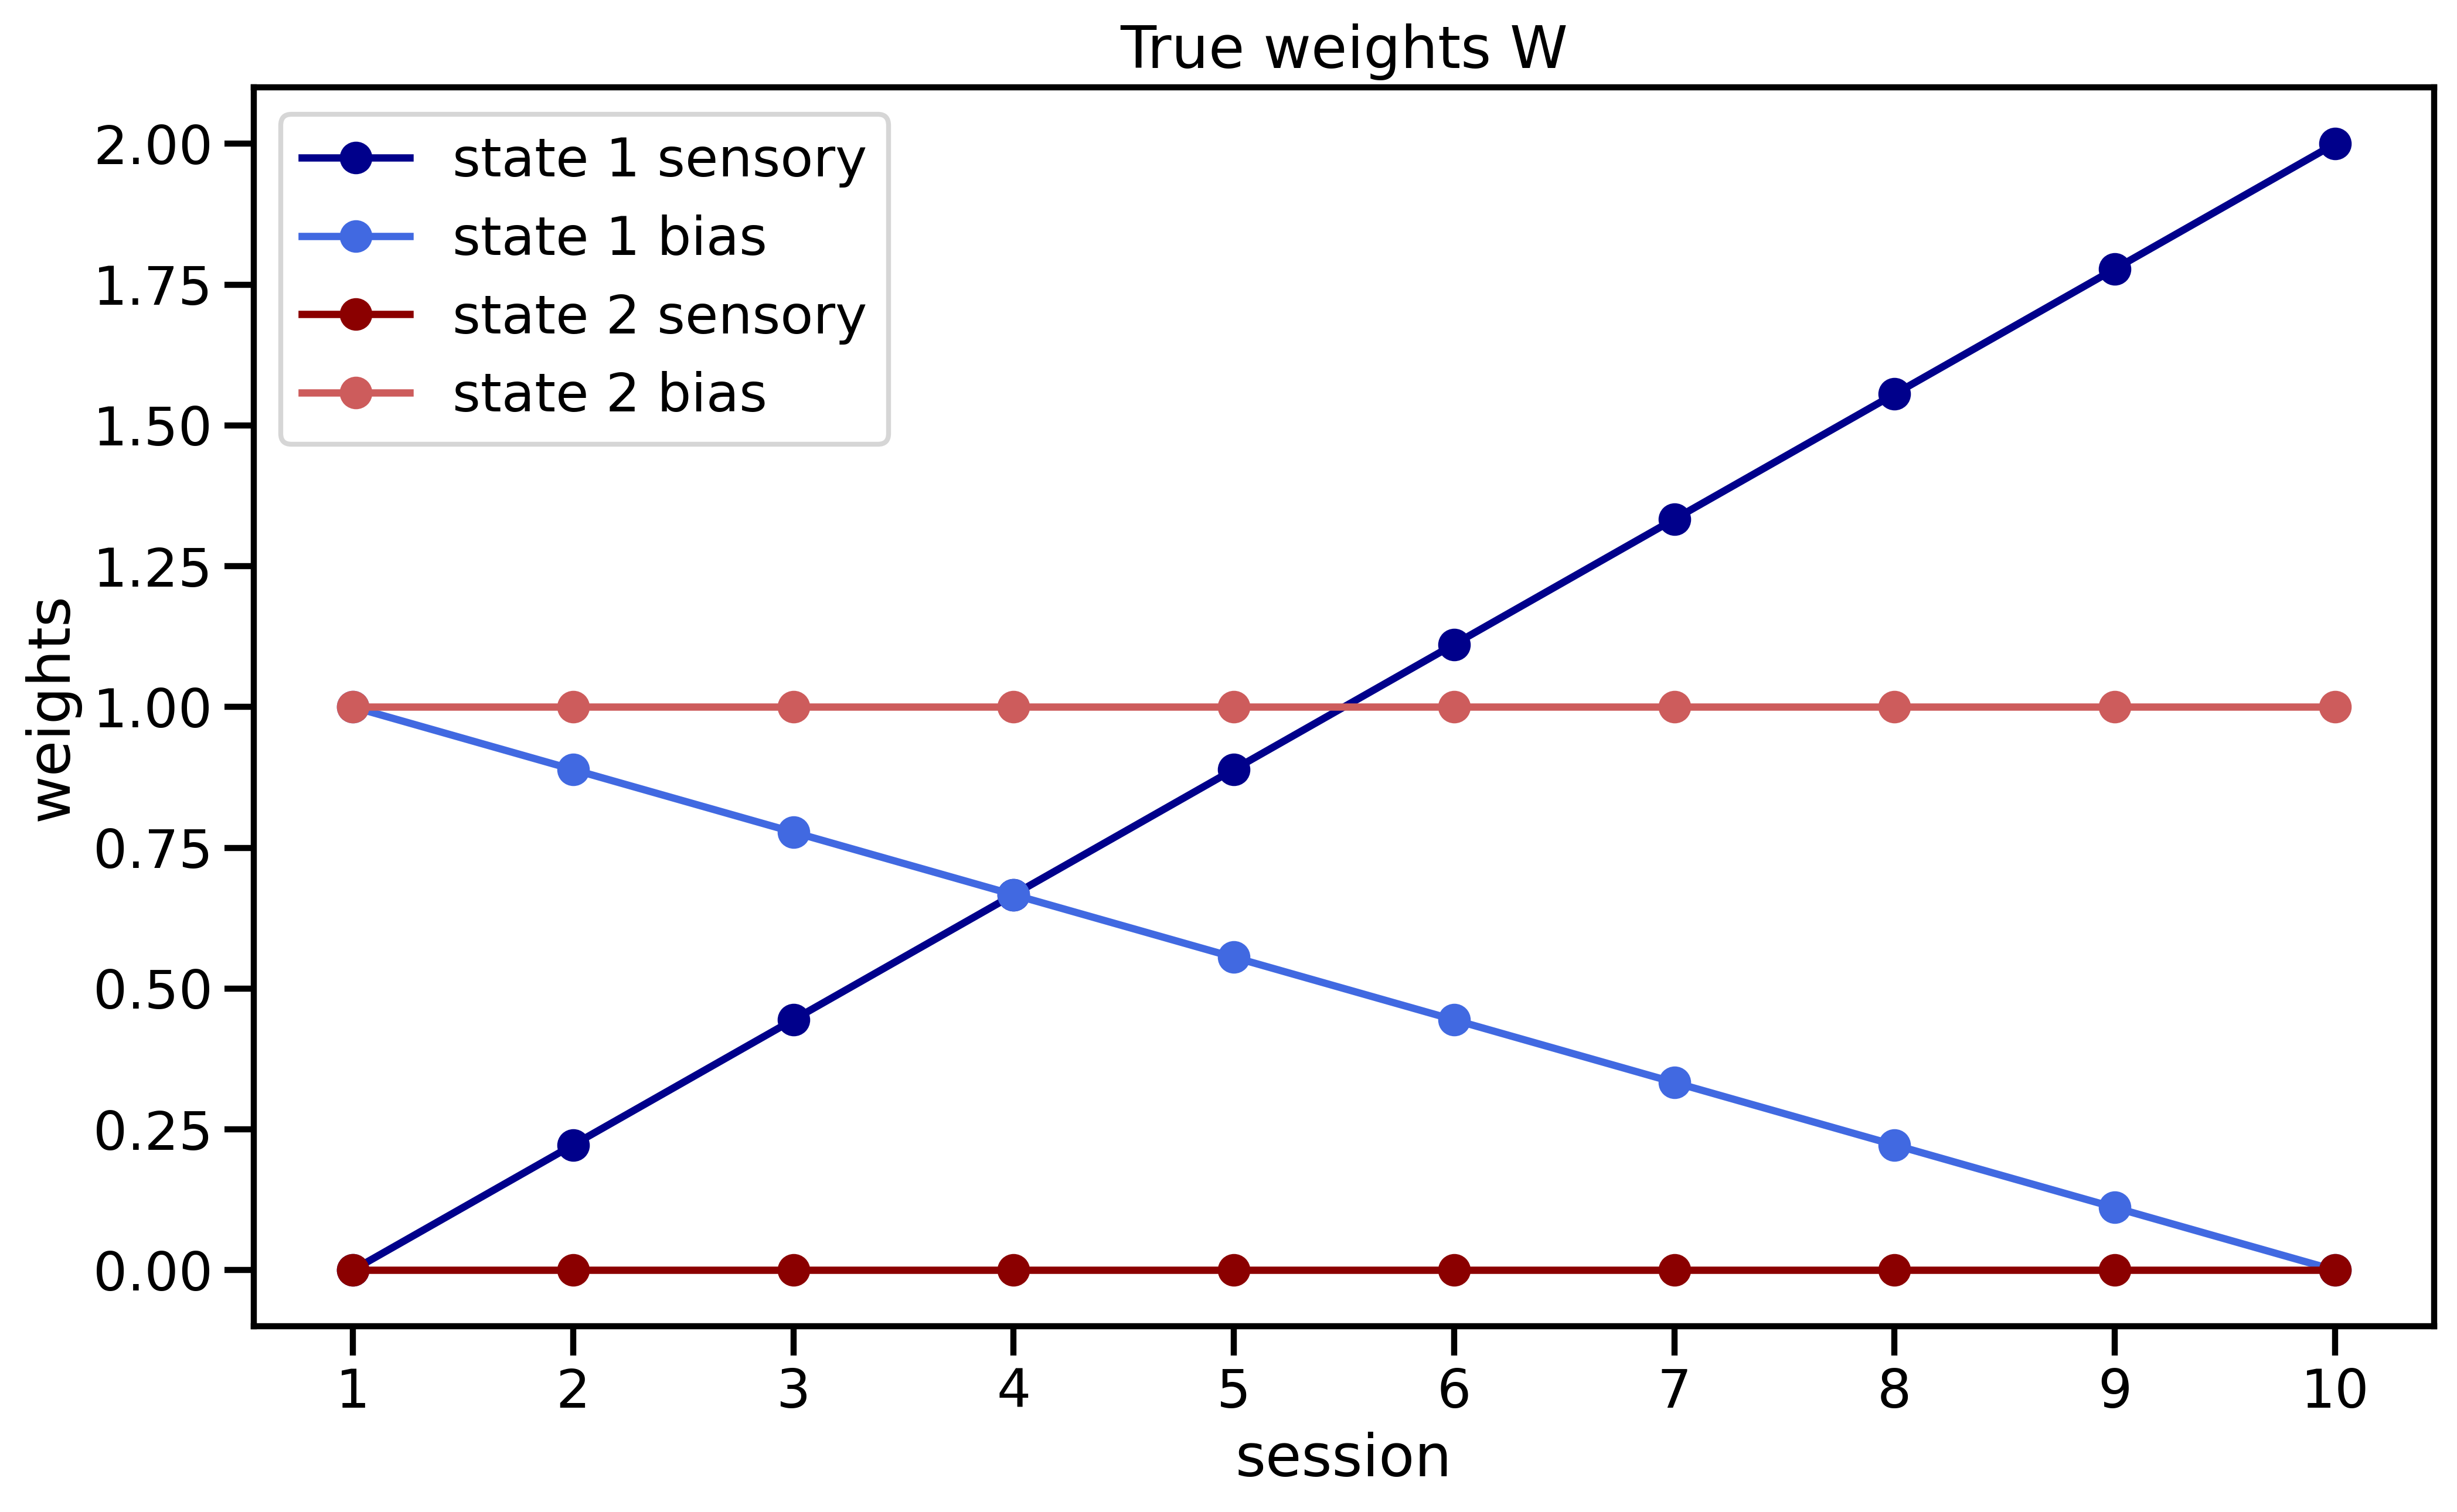

In [4]:
# True Weights and Session Start Indices
ourW = np.zeros((S,K,D))
ourW[:,0,1] = np.linspace(0,2,S) # state 1 sensory (increasing)
ourW[:,0,0] = np.linspace(1,0,S) # state 1 bias (decreasing)
ourW[:,1,1] = 0 # state 2 sensory (flat 0)
ourW[:,1,0] = 1 # state 2 bias (flat 1)
trueW = np.zeros((N,K,D,C))
# change weight format to have session*trials points
sessInd = []
for sess in range(0,S):
    sessInd.append(sess*T)
    for t in range(0,T):
        trueW[sess*T+t,:,:,0] = ourW[sess,:,:]
sessInd.append(N)
print("Session indicies")
print(sessInd)

testSessInd = []
for sess in range(0,S+1):
    testSessInd.append(sess*1000)

print(trueW.shape)
fig, axes = plt.subplots(1, figsize = (12,7), dpi=400)
plotting_weights(w=trueW, sessInd=sessInd, axes=axes, trueW=None, title='True weights W', save_fig=False)

In [5]:
dGLMHMM = dglm_hmm2.dGLM_HMM2(N,K,D,C)
x, y, z = dGLMHMM.simulate_data(trueW, trueP, sessInd, save=True, title='constantP-sim', pi0=0.5)
# trainX = np.load('../data/N=5000_2_state_constant-drift_trainX.npy')
# trainY = np.load('../data/N=5000_2_state_constant-drift_trainY.npy')

In [6]:
oneSessInd = [0,N]
initP0, initW0 = dGLMHMM.generate_param(sessInd=oneSessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['uniform', (-2,2)]) 
initP,  initW, _ = dGLMHMM.fit(x, y,  initP0, initW0, sigma=reshapeSigma(1, K, D), sessInd=oneSessInd, pi0=None, maxIter=300, tol=1e-4) # sigma does not matter here
checkP, checkW, checkLl = dGLMHMM.fit(x, y,  initP=initP, initW=initW, sigma=reshapeSigma(0.2, K, D), sessInd=sessInd, pi0=None, maxIter=300, tol=1e-4) # fit the model


0
10
20
30
40
50
60


KeyboardInterrupt: 

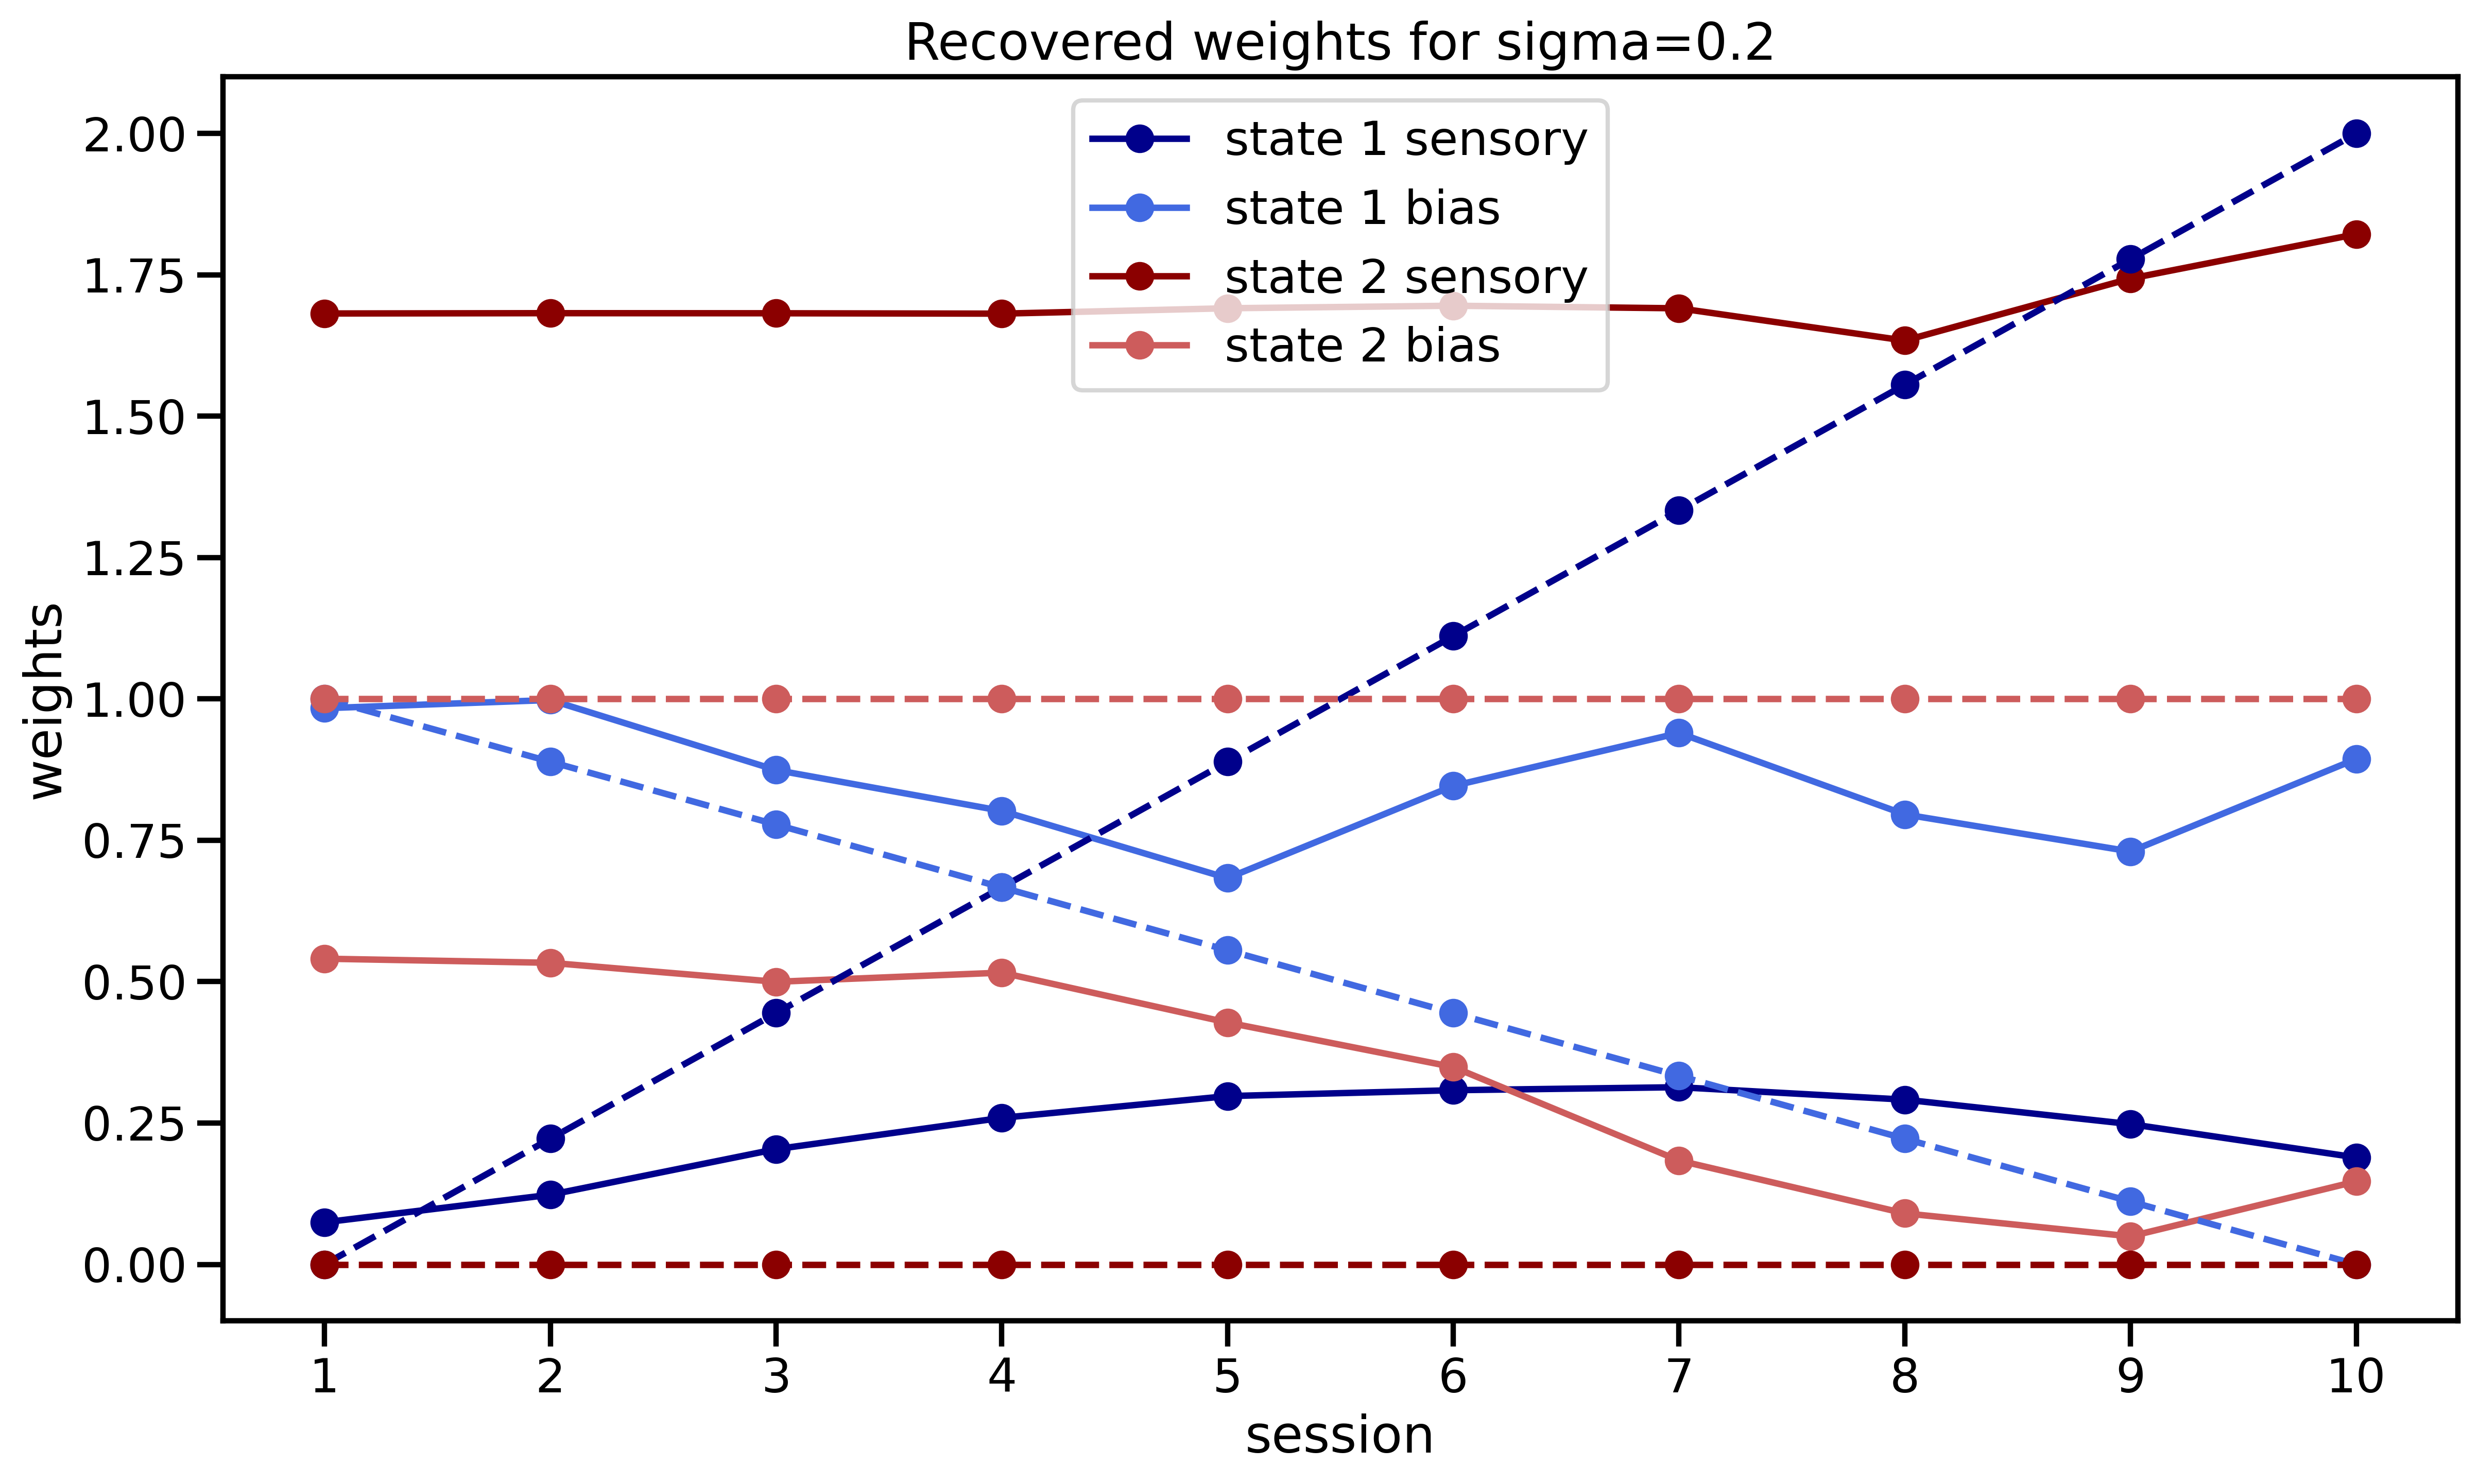

In [7]:
fig, axes = plt.subplots(1, figsize = (14,8), dpi=400)
sortedStatesInd = permute_states(checkW,sessInd)
plotting_weights(checkW[:,sortedStatesInd,:,:], sessInd, axes=axes,  trueW=trueW, title=f'Recovered weights for sigma=0.2', save_fig=False)

In [11]:
for sess in range(0,S):
    print(checkP[sess*T])

[[9.98875194e-01 1.12480628e-03]
 [1.00000000e+00 4.13382199e-26]]
[[0.9592497  0.0407503 ]
 [0.29413481 0.70586519]]
[[0.98693038 0.01306962]
 [0.08839917 0.91160083]]
[[0.94451377 0.05548623]
 [0.14924485 0.85075515]]
[[9.92409881e-01 7.59011897e-03]
 [1.00000000e+00 8.26480275e-11]]
[[0.91270106 0.08729894]
 [0.21712733 0.78287267]]
[[0.96787324 0.03212676]
 [0.04214464 0.95785536]]
[[0.94891057 0.05108943]
 [0.03027886 0.96972114]]
[[0.98721472 0.01278528]
 [0.01356802 0.98643198]]
[[0.93056749 0.06943251]
 [0.04325955 0.95674045]]


### Transition matrix is different for each session

In [10]:
# True Transition Matrix
ourP = np.zeros((2,2))
ourP[0,0]=0.97
ourP[0,1]=0.03
ourP[1,0]=.05
ourP[1,1]=.95
print("True Transition Matrix P")
print(ourP)

# trueP = np.zeros((N,K,K))
# for sess in range(0,S):
#     a = np.random.dirichlet(np.ones((K))+(K)*ourP[0])
#     b = np.random.dirichlet(np.ones((K))+(K)*ourP[1])
#     for t in range(0,T):
#         trueP[sess*T+t,0] = a
#         trueP[sess*T+t,1] = b
#np.save(f'../data/M2-TrueP-random', trueP)
trueP = np.load('../data/M2-TrueP-random.npy')

print(trueP[0])

True Transition Matrix P
[[0.97 0.03]
 [0.05 0.95]]
[[0.72031301 0.27968699]
 [0.02656842 0.97343158]]


In [14]:
dGLMHMM = dglm_hmm2.dGLM_HMM2(N,K,D,C)
# x, y, z = dGLMHMM.simulate_data(trueW, trueP, sessInd, save=True, title='randomP-sim', pi0=0.5)
x = np.load('../data/M2_randomP-simX.npy')
y = np.load('../data/M2_randomP-simY.npy')
z = np.load('../data/M2_randomP-simZ.npy')

2874
